# Final project. Telecom
**Customer** is a telecom operator that wants to fight customer churn. In order to proactively find such users who want to cancel services, a model is needed that will predict whether a subscriber will cancel the contract. 

Thus, **the main task of the project** is to create and train a model based on the collected data to predict customer churn.

The data is stored in a PostgreSQL database and includes personal information about some customers as well as their tariffs and services. The contract information is current as of February 1, 2020.

**Progress:**
1. [Data loading](#loading)
2. [Data preprocessing and EDA](#analysis)
3. [Model training](#training)
4. [Testing the best model](#testing)
5. [Conclusions](#result)


### Description of Services:

The operator provides two main types of services:
1. Landline telephone service. The telephone can be connected to several lines at the same time.
2. Internet. Connection is of two types: via DSL (digital subscriber line) or fiber optic cable (fiber optic).

A number of services are also available to subscribers:
- Internet security: antivirus (Device Protection) and blocking of dangerous sites (Online Security);
- Dedicated line of technical support (Tech Support);
- Cloud file storage for data backup (Online Backup);
- Streaming TV and Streaming Movies catalog.

Customers can pay for services monthly or every 1-2 years. Various payment methods and the possibility to receive an electronic check are available.

### Description of the data in the database
Tables:
- `contract` - information about contracts;
- `personal` - personal data of clients;
- `internet` - information about Internet services;
- `phone` - information about telephony services.

Table `telecom.contract`:
- `customerID` - subscriber ID;
- `BeginDate` - contract start date;
- `EndDate` - date when the contract expires;
- `Type` - type of payment: once in a year or two or monthly;
- `PaperlessBilling` - electronic billing sheet;
- `PaymentMethod` - payment type;
- `MonthlyCharges` - expenses per month;
- `TotalCharges` - total expenses of the subscriber.

Table `personal`:
- `customerID` - user ID;
- `gender` - gender;
- `SeniorCitizen` - whether the subscriber is a pensioner;
- `Partner` - whether the subscriber has a spouse;
- `Dependents` - whether the subscriber has children.

Table `telecom.internet`:
- `customerID` - user ID;
- `InternetService` - type of connection;
- `OnlineSecurity` - blocking of dangerous sites;
- `OnlineBackup` - cloud file storage for data backup;
- `DeviceProtection` - antivirus;
- `TechSupport` - dedicated technical support line;
- `StreamingTV` - streaming television;
- `StreamingMovies` - movie catalog.

Table `telecom.phone`:
- `customerID` - user ID;
- `MultipleLines` - connection of the phone to several lines simultaneously.

  <a id='loading'></a>
  ## Data loading

In [1]:
!pip install catboost -q
!pip install scikeras -q
!pip install phik -q

In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from phik import phik_matrix

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from catboost import CatBoostClassifier

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier

In [3]:
RANDOM_STATE = 24923

In [4]:
# import dictionary containing db connection info
from config import db_config 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
# creating a connection
engine = create_engine(connection_string)

Connection to the PostgreSQL database is successful. Let's load individual tables.

In [6]:
# function for loading a table by name
def load_table_from_db(table_name, engine):
  query = f'SELECT * FROM telecom.{table_name};'

  return pd.read_sql_query(text(query), con=engine.connect())

In [7]:
# contract
contract_df = load_table_from_db('contract', engine)
print('Contract')
display(contract_df.head(2))
print()

# personal
personal_df = load_table_from_db('personal', engine)
print('Personal')
display(personal_df.head(2))
print()

# internet
internet_df = load_table_from_db('internet', engine)
print('Internet')
display(internet_df.head(2))
print()

# phone
phone_df = load_table_from_db('phone', engine)
print('Phone')
display(phone_df.head(2))
print()

Contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN



Personal


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No



Internet


,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No



Phone


,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No


When loading the last two tables, the headers are in the first row. Let's fix it.

In [8]:
# table internet
internet_df.columns = internet_df.iloc[0]
internet_df.drop([0], inplace=True)
internet_df.head(2)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No


In [9]:
# table phone
phone_df.columns = phone_df.iloc[0]
phone_df.drop([0], inplace=True)
phone_df.head(2)

,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No


All required tables have been successfully loaded and contain data. The number of tables corresponds to the task condition. You can start analyzing and preprocessing.

<a id='analysis'></a>
## Data preprocessing and EDA

Let's look at each table separately.

### Table contract
This table contains information about contracts.

In [10]:
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [11]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


There are a total of 7043 rows of data in the table. There are 8 columns. Two of them contain dates (`BeginDate`, `EndDate`) - let's convert them to the expected data type.


In [12]:
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'])
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'])

In [13]:
contract_df['BeginDate'].describe(datetime_is_numeric=True)

count                             7043
mean     2019-03-20 03:51:02.274599168
min                2018-04-17 00:00:00
25%                2019-01-18 12:00:00
50%                2019-03-22 00:00:00
75%                2019-05-21 00:00:00
max                2020-02-01 00:00:00
Name: BeginDate, dtype: object

In [14]:
contract_df['EndDate'].describe(datetime_is_numeric=True)

count                             1869
mean     2019-11-15 21:31:18.009630720
min                2019-10-01 00:00:00
25%                2019-11-01 00:00:00
50%                2019-11-01 00:00:00
75%                2019-12-01 00:00:00
max                2020-01-01 00:00:00
Name: EndDate, dtype: object

The dataset contains data for contracts starting in April 2018 and ending in February 2020, as indicated at the beginning. The latest recorded end date is 01.01.2020.

In [15]:
# missing values
contract_df.isna().sum()

customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
dtype: int64

At the same time, there are gaps in two columns: `EndDate' and `TotalCharges'.

The large number of omissions in the `EndDate` column can be explained by the fact that the client was still "active" at the time of data collection. There is no need to fill them in.

The gaps in the second column (`TotalCharges`) can be filled with data from the neighboring column `MonthlyCharges` assuming that the client simply did not have data in other expenses.

In [16]:
contract_df.loc[contract_df['TotalCharges'].isna(), 'TotalCharges'] = contract_df.loc[contract_df['TotalCharges'].isna(), 'MonthlyCharges']

In [17]:
contract_df['TotalCharges'].isna().sum()

0

We will also check the numerical signs for abnormal values and look at their distributions.

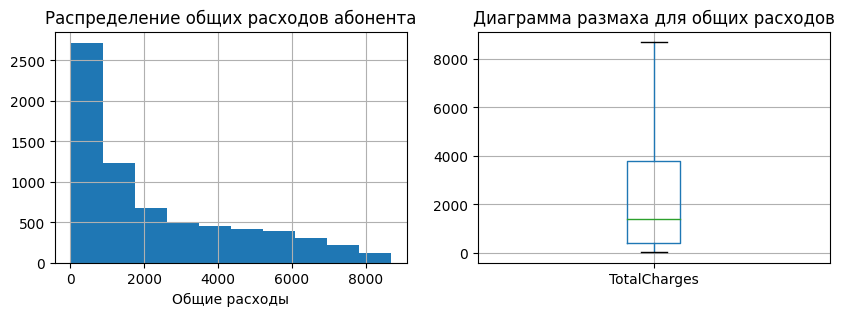

In [18]:
plt.figure(figsize=(10, 3))
plt.subplot (1, 2, 1)
contract_df['TotalCharges'].hist()
plt.title('Распределение общих расходов абонента')
plt.xlabel('Общие расходы')

plt.subplot(1, 2, 2)
contract_df.boxplot('TotalCharges')
plt.title('Диаграмма размаха для общих расходов')
plt.show()

In [19]:
# check 0
contract_df[contract_df['TotalCharges'] == 0]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


No outliers are observed in the `TotalCharges` column, no zero values are observed either. The distribution is similar to exponential distribution.

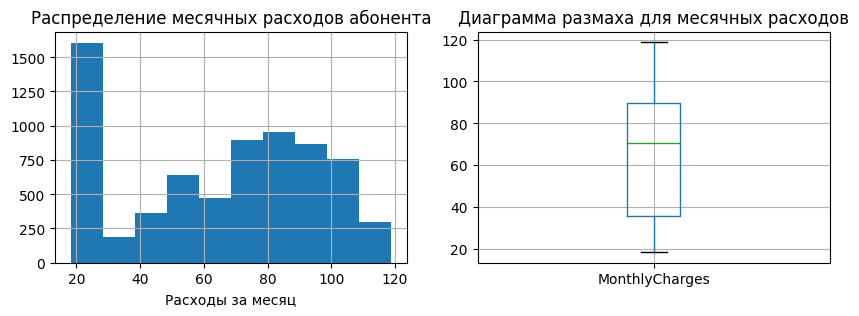

In [20]:
plt.figure(figsize=(10, 3))
plt.subplot (1, 2, 1)
contract_df['MonthlyCharges'].hist()
plt.title('Распределение месячных расходов абонента')
plt.xlabel('Расходы за месяц')

plt.subplot(1, 2, 2)
contract_df.boxplot('MonthlyCharges')
plt.title('Диаграмма размаха для месячных расходов')
plt.show()

For monthly expenses, the graph looks a bit different: the distribution could be similar to a normal distribution, if it were not for the sharp peak in the region of 20. Most likely, it reflects the minimum monthly amounts for tariffs.

Now let's take a closer look at the categorical variables.

In [21]:
contract_df['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [22]:
contract_df['PaperlessBilling'].value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

In [23]:
contract_df['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

The number of categories in each column is acceptable, no implicit duplicates.

The `PaperlessBilling` attribute is binary. Let us immediately encode the yes-no values into 1-0 for ease of understanding.

In [24]:
contract_df['PaperlessBilling'] = contract_df['PaperlessBilling'].apply(lambda x: 0 if x == 'No' else 1)
contract_df['PaperlessBilling'].value_counts()

1    4171
0    2872
Name: PaperlessBilling, dtype: int64

In [25]:
# duplicate check
contract_df.duplicated().sum()

0

In [26]:
# unique client check
contract_df.duplicated(subset='customerID').sum()

0

All rows in the table are unique and refer to different customers.

### Table personal
This table contains personal data of clients.

In [27]:
personal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [28]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [29]:
personal_df.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

As in the previous table, the total number of rows is 7043. No omissions are observed. All presented attributes are categorical.

In [30]:
personal_df['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [31]:
personal_df['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [32]:
personal_df['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

In [33]:
personal_df['Dependents'].value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

Some of the attributes contain yes-no values. Let's convert them to 0-1.

In [34]:
for col in ['Partner', 'Dependents']:
  personal_df[col] = personal_df[col].apply(lambda x: 0 if x == 'No' else 1)

In [35]:
personal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,1,0
1,5575-GNVDE,Male,0,0,0
2,3668-QPYBK,Male,0,0,0
3,7795-CFOCW,Male,0,0,0
4,9237-HQITU,Female,0,0,0


In [36]:
# duplicate check
personal_df.duplicated().sum()

0

In [37]:
# unique client check
personal_df.duplicated(subset=['customerID']).sum()

0

The clients in the table are unique.

### Internet table
This table stores information about internet services.

In [38]:
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [39]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [40]:
internet_df.isna().sum()

0
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

The table contains 5517 rows, there are no omissions in the data. All attributes are categorical, most of them are binary.

In [41]:
internet_df['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

In [42]:
internet_df['OnlineSecurity'].value_counts()

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

In [43]:
internet_df['OnlineBackup'].value_counts()

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

In [44]:
internet_df['DeviceProtection'].value_counts()

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

In [45]:
internet_df['TechSupport'].value_counts()

No     3473
Yes    2044
Name: TechSupport, dtype: int64

In [46]:
internet_df['StreamingTV'].value_counts()

No     2810
Yes    2707
Name: StreamingTV, dtype: int64

In [47]:
internet_df['StreamingMovies'].value_counts()

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64

Similarly, let's convert the yes-no answers to 1-0.

In [48]:
internet_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in internet_cols:
  internet_df[col] = internet_df[col].apply(lambda x: 0 if x == 'No' else 1)

In [49]:
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,0,1,0,0,0,0
2,5575-GNVDE,DSL,1,0,1,0,0,0
3,3668-QPYBK,DSL,1,1,0,0,0,0
4,7795-CFOCW,DSL,1,0,1,1,0,0
5,9237-HQITU,Fiber optic,0,0,0,0,0,0


In [50]:
# unique values
internet_df['InternetService'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

In [51]:
# duplicate check
internet_df.duplicated().sum()

0

In [52]:
# unique client check
internet_df.duplicated(subset=['customerID']).sum()

0

### Table phone
Contains information about telephony services.

In [53]:
phone_df.head()

,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes


In [54]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 1 to 6361
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [55]:
phone_df.isna().sum()

0
customerID       0
MultipleLines    0
dtype: int64

This table contains 6361 rows and only 1 attribute - whether the phone is connected to multiple lines at the same time.

In [56]:
phone_df['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

Since this feature contains yes-no values we will also translate them to 1-0.

In [57]:
phone_df['MultipleLines'] = phone_df['MultipleLines'].apply(lambda x: 0 if x == 'No' else 1)

In [58]:
phone_df.head()

,customerID,MultipleLines
1,5575-GNVDE,0
2,3668-QPYBK,0
3,9237-HQITU,0
4,9305-CDSKC,1
5,1452-KIOVK,1


In [59]:
# duplicate check
phone_df.duplicated().sum()

0

In [60]:
# unique client check
phone_df.duplicated(subset=['customerID']).sum()

0

**Summary :**
Based on the results of the exploratory data analysis, the number of tables is as expected, with all loaded tables containing data with no duplicates. Customer information in rows is also free of duplicates.

Gaps were found in only two columns of the `conract` table. In the `EndDate` column they identified current customers, so it was decided not to fill them in at this stage. In contrast, in the column with total client expenditure, the omissions were filled in with values from the adjacent column with monthly expenditure. There were also a couple of columns containing dates in the `contract' table. These were normalized to the appropriate format. The data types in all other columns in the table, and all other tables, were as expected. No anomalies were found in any columns.

Additionally, for convenience, all binary attributes in all tables (with possible yes-no values) were converted to numeric format (values 0 = "no", 1 = "yes").

Now the tables are ready, we can start merging them.

### Merging tables

All loaded tables have been reviewed individually and tweaked. Let's try to merge them by client ID.

In [61]:
data = contract_df.merge(personal_df, on='customerID')
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents
0,4472-LVYGI,2020-02-01,NaT,Two year,1,Bank transfer (automatic),52.55,52.55,Female,0,1,1
1,3115-CZMZD,2020-02-01,NaT,Two year,0,Mailed check,20.25,20.25,Male,0,0,1
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,Male,0,0,0
3,5709-LVOEQ,2020-02-01,NaT,Two year,0,Mailed check,80.85,80.85,Female,0,1,1
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,Female,0,0,0


In [62]:
data.shape

(7043, 12)

Both tables had the same number of rows and unique clients before the merge. In the single table after the merge it remained the same.

In the other two tables the amount of rows is less and also all clients are unique. Let's apply a left-to-right merge to keep all existing customers.

In [63]:
data = data.merge(internet_df, on='customerID', how='left')
data = data.merge(phone_df, on='customerID', how='left')

In [64]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,4472-LVYGI,2020-02-01,NaT,Two year,1,Bank transfer (automatic),52.55,52.55,Female,0,1,1,DSL,1.0,0.0,1.0,1.0,1.0,0.0,NaN
1,3115-CZMZD,2020-02-01,NaT,Two year,0,Mailed check,20.25,20.25,Male,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,Male,0,0,0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,5709-LVOEQ,2020-02-01,NaT,Two year,0,Mailed check,80.85,80.85,Female,0,1,1,DSL,1.0,1.0,1.0,0.0,1.0,1.0,0.0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,Female,0,0,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   int64         
 11  Dependents        7043 non-null   int64         
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   float64       
 14  OnlineBackup      5517 n


Thus, we have gaps in the columns related to internet connection and phone connection. Most likely, the "internet" table does not contain data on users who have not connected the internet at all, and the "phone" table does not contain data on users who have not connected the phone.

To eliminate the gaps in the Internet-related columns, we will enter an additional category in the "InternetService" column and set 0 ("No") in all others.

In [66]:
data['InternetService'] = data['InternetService'].fillna('No')

In [67]:
internet_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in internet_cols:
  data[col] = data[col].fillna(0)
  data[col] = data[col].astype(int)

We will also fill in the blanks in the "MultipleLines" column with 0 ("No") + create a new column showing whether the customer has connected a phone connection.

In [68]:
# new column
data['phone'] = data['MultipleLines'].apply(lambda x: 0 if x != x else 1)

In [69]:
data['MultipleLines'] = data['MultipleLines'].fillna(0).astype(int)

Create a target variable `terminated` based on the `EndDate` attribute: put there the information about whether the client left or not.

In [70]:
data['terminated'] = data['EndDate'].apply(lambda x: 0 if x != x else 1)

Now we can fill in the gaps in the column with the contract expiration date. Since we know that the data is current as of 01.02.2020, we will use this date as the end date for "active" clients.

In [71]:
data['EndDate'] = data['EndDate'].fillna('2020-02-01')

Due to this, we will additionally highlight a feature based on date differences - *subscriber contract length in days*.

In [72]:
def contract_duration(row):
  begin_date = row['BeginDate']
  end_date = row['EndDate']
  row['duration'] = (end_date - begin_date).days + 1

  return row

In [73]:
data['duration'] = np.nan
data = data.apply(contract_duration, axis=1)

In [74]:
data.head(2)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,phone,terminated,duration
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,52.55,Female,0,...,1,0,1,1,1,0,0,0,0,1
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,20.25,Male,0,...,0,0,0,0,0,0,0,1,0,1


Let's try to create another attribute based on it, namely "consumption per day" by dividing `TotalCharges` by `duration`.

In [75]:
data['day_charges'] = data['TotalCharges'] / data['duration']
data.head(2)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,phone,terminated,duration,day_charges
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,52.55,Female,0,...,0,1,1,1,0,0,0,0,1,52.55
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,20.25,Male,0,...,0,0,0,0,0,0,1,0,1,20.25


### Data preparation and feature selection
Since the data in the following sections will be used for machine learning, let's move on to feature revision.

Let's immediately remove uninformative attributes, namely: `BeginDate` (strongly related to the new attribute `duration`), `EndDate` (initially most of the values were missing) and `customerID` (unique customer identifiers)

In [76]:
data.drop(columns=['BeginDate', 'EndDate', 'customerID'], inplace=True)

Let's look at the correlations of the target variable with the traits:

In [77]:
phik_matrix(data).sort_values(by='terminated', ascending=False).style.background_gradient(cmap='Greens')

interval columns not set, guessing: ['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'phone', 'terminated', 'duration', 'day_charges']


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,phone,terminated,duration,day_charges
terminated,0.251639,0.295754,0.449125,0.360050,0.279152,0.000000,0.233432,0.232930,0.253936,0.196202,0.264580,0.126973,0.101516,0.254615,0.096865,0.093923,0.059581,0.000000,1.000000,0.034597,0.000000
PaymentMethod,0.277462,0.370495,1.000000,0.399526,0.350460,0.000000,0.292725,0.243008,0.224903,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.339313,0.000000,0.449125,0.000868,0.000000
MonthlyCharges,0.388444,0.467812,0.399526,1.000000,0.762889,0.008175,0.304985,0.203545,0.184366,0.919002,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307,0.675883,0.831362,0.360050,0.015962,0.043334
PaperlessBilling,0.106860,1.000000,0.370495,0.467812,0.205901,0.000000,0.242133,0.013218,0.172593,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.252972,0.016811,0.295754,0.050069,0.000000
TotalCharges,0.505287,0.205901,0.350460,0.762889,1.000000,0.000000,0.148755,0.422402,0.114304,0.508171,0.544407,0.655082,0.671222,0.565910,0.659672,0.666350,0.605753,0.197703,0.279152,0.010908,0.094523
OnlineSecurity,0.152145,0.000000,0.262911,0.551621,0.544407,0.018397,0.057028,0.221673,0.124945,0.241421,1.000000,0.430425,0.418474,0.528391,0.272186,0.289097,0.151886,0.143385,0.264580,0.000000,0.011578
TechSupport,0.179999,0.055929,0.272101,0.576525,0.565910,0.000000,0.092565,0.185993,0.096912,0.239663,0.528391,0.445130,0.499267,1.000000,0.422242,0.424078,0.155739,0.148788,0.254615,0.000000,0.015316
Dependents,0.147680,0.172593,0.224903,0.184366,0.114304,0.000000,0.324576,0.652122,1.000000,0.108463,0.124945,0.031533,0.010416,0.096912,0.017331,0.058999,0.033103,0.000000,0.253936,0.035546,0.010272
Type,1.000000,0.106860,0.277462,0.388444,0.505287,0.000000,0.086231,0.179736,0.147680,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.065498,0.000000,0.251639,0.037860,0.068204
SeniorCitizen,0.086231,0.242133,0.292725,0.304985,0.148755,0.000000,1.000000,0.016992,0.324576,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.221313,0.000000,0.233432,0.034522,0.000000


There are three attributes with which there is almost zero correlation in the target variable: `phone`, `gender` and `day_charges`. Let's remove them from the dataframe.

We also observe strong correlations of some features with each other: for example, the `MonthlyCharges` feature correlates with almost half of the other features, which may not reflect well on model training. However, this attribute has one of the highest correlation coefficients with the target variable, so we will not delete it.

In [78]:
data.drop(columns=['phone', 'gender', 'day_charges'], inplace=True)

Dependence of the target variable on categorical attributes with three or more values.

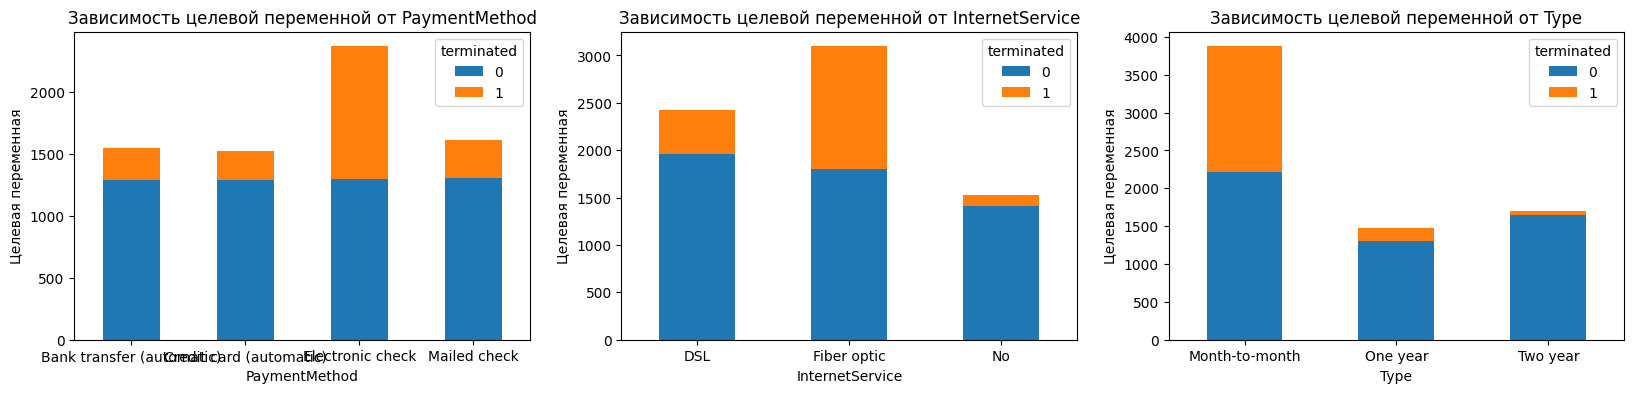

In [79]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))

cat_cols = ['Type', 'PaymentMethod', 'InternetService']
for i, column in enumerate(cat_cols):
    ax = axes[i-1]
    data.pivot_table(index=column, columns='terminated', aggfunc='size').plot(kind='bar', stacked=True, ax=ax)

    ax.set_xlabel(column)
    ax.set_ylabel('Целевая переменная')
    ax.set_title(f'Зависимость целевой переменной от {column}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


plt.show()

Thus, the final dataframe after merging and feature selection:

In [80]:
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,terminated,duration
0,Two year,1,Bank transfer (automatic),52.55,52.55,0,1,1,DSL,1,0,1,1,1,0,0,0,1
1,Two year,0,Mailed check,20.25,20.25,0,0,1,No,0,0,0,0,0,0,0,0,1
2,Month-to-month,1,Mailed check,53.85,108.15,0,0,0,DSL,1,1,0,0,0,0,0,1,480
3,Two year,0,Mailed check,80.85,80.85,0,1,1,DSL,1,1,1,0,1,1,0,0,1
4,Month-to-month,1,Electronic check,70.70,151.65,0,0,0,Fiber optic,0,0,0,0,0,0,0,1,280


In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   int64  
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   SeniorCitizen     7043 non-null   int64  
 6   Partner           7043 non-null   int64  
 7   Dependents        7043 non-null   int64  
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   int64  
 10  OnlineBackup      7043 non-null   int64  
 11  DeviceProtection  7043 non-null   int64  
 12  TechSupport       7043 non-null   int64  
 13  StreamingTV       7043 non-null   int64  
 14  StreamingMovies   7043 non-null   int64  
 15  MultipleLines     7043 non-null   int64  
 16  terminated        7043 non-null   int64  


Considering the distribution of the target variable:

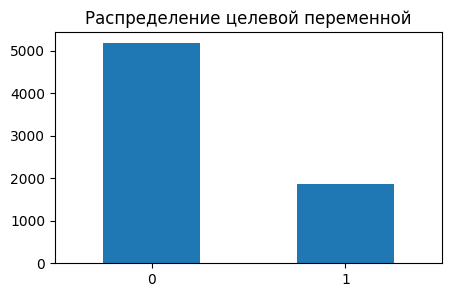

0    0.73463
1    0.26537
Name: terminated, dtype: float64

In [82]:
data['terminated'].value_counts().plot(kind='bar', figsize=(5, 3))
plt.xticks(rotation=0)
plt.title('Распределение целевой переменной')
plt.show()
data['terminated'].value_counts(normalize=True)

There is a clear imbalance of classes 1 to 4 in the dataset, however, it is not critical if we use machine learning algorithms that are relatively resistant to it. Let's divide the dataset into samples.

In [83]:
features = data.drop(columns=['terminated'])
target = data['terminated']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, stratify=target, random_state=RANDOM_STATE)

features_train.shape, features_test.shape

((5282, 17), (1761, 17))

In [84]:
data.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines',
       'terminated', 'duration'],
      dtype='object')

Before training the models, we will also need to scale the numerical features and encode the categorical features.  Binary attributes will not be changed.

In [85]:
# numeric features
numeric = ['TotalCharges', 'MonthlyCharges', 'duration']

# categorical features
categorical = ['Type', 'PaymentMethod', 'InternetService']

# binary features
other = ['PaperlessBilling', 'SeniorCitizen', 'Dependents', 'OnlineSecurity', 'TechSupport', 'Partner',
         'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
#

# preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(drop='first'), categorical),
        ('other', 'passthrough', other)])

<a id='training'></a>
## Model training
We will use pipelines for convenience. Let's consider three classes of models in sequence:
- *Random Forest.*
- *Gradient boosting*
- *Neural network*.

We will use ROC-AUC as a quality assessment metric.

In [86]:
%%time
# Random forest
params = {'rf__n_estimators': range(15, 20, 1),
          'rf__max_depth': range(3, 5)}

pipe = Pipeline(steps=[
    ('preprocessor',  preprocessor),
    ('rf', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])

grid = GridSearchCV(pipe, param_grid=params, scoring='roc_auc', cv=10, n_jobs=4)
grid.fit(features_train, target_train)
rf_model = grid.best_estimator_

print("Лучшие параметры: {}".format(grid.best_params_))
print("Лучший результат (ROC-AUC): {:.6f}".format(grid.best_score_))
print()

Лучшие параметры: {'rf__max_depth': 4, 'rf__n_estimators': 16}
Лучший результат (ROC-AUC): 0.837041

CPU times: user 1.07 s, sys: 93.9 ms, total: 1.16 s
Wall time: 13 s


For gradient boosting, let's try 2 variants: one with embedded encoding and one with regular encoding.

In [87]:
# scaling
scaler = StandardScaler()
scaled_features_train = features_train.copy(deep=True)
scaled_features_train[numeric] = scaler.fit_transform(features_train[numeric])

In [88]:
%%time
# Gradient boosting
params = {'catboost__n_estimators': range(16, 20, 1),
          'catboost__max_depth': range(3, 5),
          'catboost__learning_rate': [0.01, 0.1, 0.2]}

# first option: catboost encoding
pipe = Pipeline(steps=[
    ('catboost', CatBoostClassifier(random_state=RANDOM_STATE,
                                    l2_leaf_reg=1,
                                    class_weights={0: 1, 1: 4},
                                    cat_features=categorical+other,
                                    verbose=0))])

grid = GridSearchCV(pipe, param_grid=params, scoring='roc_auc', cv=10, n_jobs=4)
grid.fit(scaled_features_train, target_train)
catboost_model = grid.best_estimator_

print("Лучшие параметры: {}".format(grid.best_params_))
print("Лучший результат (ROC-AUC): {:.6f}".format(grid.best_score_))
print()

Лучшие параметры: {'catboost__learning_rate': 0.2, 'catboost__max_depth': 4, 'catboost__n_estimators': 19}
Лучший результат (ROC-AUC): 0.841993

CPU times: user 2.12 s, sys: 157 ms, total: 2.28 s
Wall time: 23 s


In [89]:
%%time
# second option: classical preprocessing
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('catboost', CatBoostClassifier(random_state=RANDOM_STATE,
                                    l2_leaf_reg=1,
                                    class_weights={0: 1, 1: 4},
                                    verbose=0))])

grid = GridSearchCV(pipe, param_grid=params, scoring='roc_auc', cv=10, n_jobs=4)
grid.fit(features_train, target_train)
catboost_model = grid.best_estimator_

print("Лучшие параметры: {}".format(grid.best_params_))
print("Лучший результат (ROC-AUC): {:.6f}".format(grid.best_score_))
print()

Лучшие параметры: {'catboost__learning_rate': 0.2, 'catboost__max_depth': 4, 'catboost__n_estimators': 19}
Лучший результат (ROC-AUC): 0.845786

CPU times: user 2.3 s, sys: 120 ms, total: 2.42 s
Wall time: 31.3 s


Judging from the results obtained, the variant with the stage of categorical features coding using OHE, shows better performance. The ROC-AUC metric is slightly higher with the same hyperparameter search.

Now let's build and train the neural network.

In [90]:
def create_net(input_shape):
  net = Sequential()
  net.add(Dense(units=128, activation='relu', input_shape=input_shape))
  net.add(Dropout(0.5))
  net.add(Dense(units=64, activation='relu'))
  net.add(Dense(units=32, activation='relu'))
  net.add(Dropout(0.5))
  net.add(Dense(units=1, activation='sigmoid'))

  optimizer = Adam(learning_rate=0.0001)
  net.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[tf.keras.metrics.AUC(curve='ROC')])

  return net

In [91]:
%%time
# training
pipe_net = Pipeline(steps=[
    ('preprocessor',  preprocessor),
    ('nn', KerasClassifier(model=create_net,
                           input_shape=(21,),
                           epochs=20, batch_size=32, verbose=1))])

pipe_net.fit(features_train, target_train)
preds = pipe_net.predict_proba(features_train)[:,1]
roc_auc = roc_auc_score(target_train, preds)

print("Лучший результат (ROC-AUC): {:.6f}".format(roc_auc))
print()

Epoch 1/20
166/166 [==============================] - 5s 7ms/step - loss: 0.6021 - auc: 0.5739
Epoch 2/20
166/166 [==============================] - 1s 7ms/step - loss: 0.5422 - auc: 0.6796
Epoch 3/20
166/166 [==============================] - 1s 5ms/step - loss: 0.5171 - auc: 0.7285
Epoch 4/20
166/166 [==============================] - 1s 5ms/step - loss: 0.5073 - auc: 0.7431
Epoch 5/20
166/166 [==============================] - 1s 6ms/step - loss: 0.4881 - auc: 0.7728
Epoch 6/20
166/166 [==============================] - 1s 5ms/step - loss: 0.4818 - auc: 0.7809
Epoch 7/20
166/166 [==============================] - 1s 5ms/step - loss: 0.4750 - auc: 0.7918
Epoch 8/20
166/166 [==============================] - 1s 5ms/step - loss: 0.4700 - auc: 0.7964
Epoch 9/20
166/166 [==============================] - 1s 5ms/step - loss: 0.4700 - auc: 0.7953
Epoch 10/20
166/166 [==============================] - 1s 6ms/step - loss: 0.4659 - auc: 0.8001
Epoch 11/20
166/166 [============================

The best result was demonstrated by the model trained with the **gradient boosting catboost** algorithm: ROC-AUC = 0.845786 using external categorical feature encoding. Neural network and random forest performed slightly worse.

<a id='testing'></a>
## Final testing

In [92]:
final_pipe = Pipeline(steps=[
    ('preprocessor',  preprocessor),
    ('catboost', CatBoostClassifier(random_state=RANDOM_STATE,
                                    l2_leaf_reg=1,
                                    class_weights={0:1, 1:4},
                                    learning_rate=0.2,
                                    max_depth=4,
                                    n_estimators=19,
                                    verbose=0))])

final_pipe.fit(features_train, target_train)

# предсказания
preds = final_pipe.predict_proba(features_test)[:, 1]
preds_classes = final_pipe.predict(features_test)

roc_auc = roc_auc_score(target_test, preds)
accuracy = accuracy_score(target_test, preds_classes)
precision = precision_score(target_test, preds_classes)
recall = recall_score(target_test, preds_classes)

print("Лучший результат (ROC-AUC): {:.6f}".format(roc_auc))
print("Accuracy: {:.6f}".format(accuracy))
print("Precision: {:.6f}".format(precision))
print("Recall: {:.6f}".format(recall))

Лучший результат (ROC-AUC): 0.850155
Accuracy: 0.696195
Precision: 0.462472
Recall: 0.897216


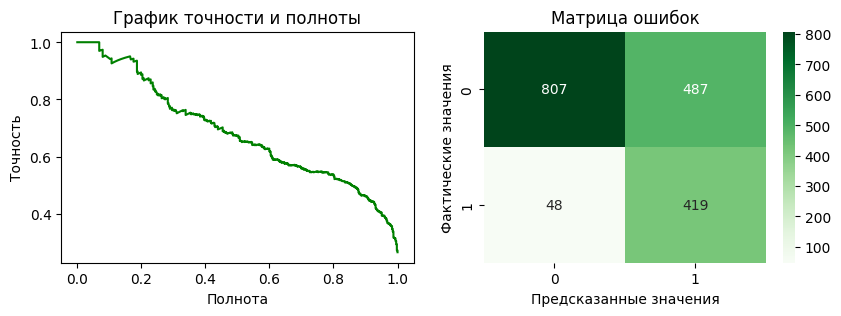

In [93]:
plt.figure(figsize=(10, 3))

# precision-recall plot
precision, recall, thresholds = precision_recall_curve(target_test, preds)
plt.subplot (1, 2, 1)
plt.plot(recall, precision, linestyle='-', color='g')
plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.title('График точности и полноты')

# confusion matrix
cm = confusion_matrix(target_test, preds_classes)
plt.subplot (1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Предсказанные значения')
plt.ylabel('Фактические значения')
plt.title('Матрица ошибок')
plt.show()

The model performed slightly better on the test sample than on the training sample: we managed to achieve the required value of the metric on the test sample. The accuracy value is also acceptable, approximately 70%. The model has a good predictive ability.

As for completeness and accuracy: the recall metric turned out to be quite high (almost 90%), unlike the precision metric, which turned out to be about 50%. Consequently, the built model tends to classify more objects as positive, but it does not always identify them correctly. This is not bad for our task, since it is more important to detect as many customers as possible who will actually leave (positive class).

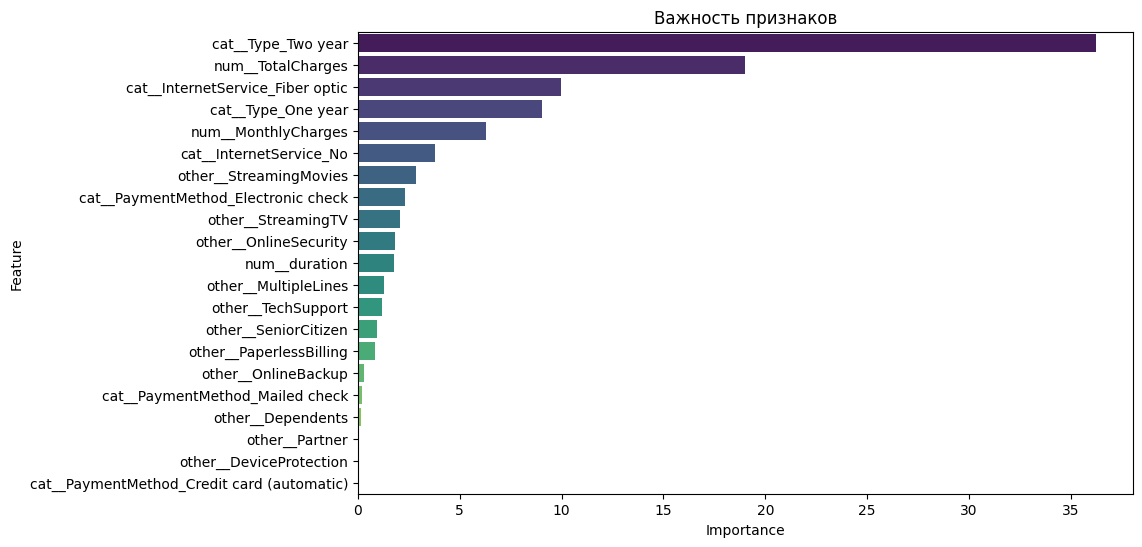

In [94]:
feature_importance = final_pipe.named_steps['catboost'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': final_pipe.named_steps['preprocessor'].get_feature_names_out(), 'Importance': feature_importance})

# sort
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Важность признаков')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


The most important attributes were `cat__Type_Two year` (payment type: every two years) and numerical attributes of expenses `num__day_charges` (expenses per day, synthesized attribute) and `num_TotalCharges` (total expenses).

In contrast, `other__Partner` (whether there is a spouse), `cat__PaymentMethod_Credit card (automatic)` (credit card payment method), and `other__DeviceProtection` (antivirus) fell into the least significant group.

For the sake of example, let us show the effect of the most important attribute on the target variable in the graph:

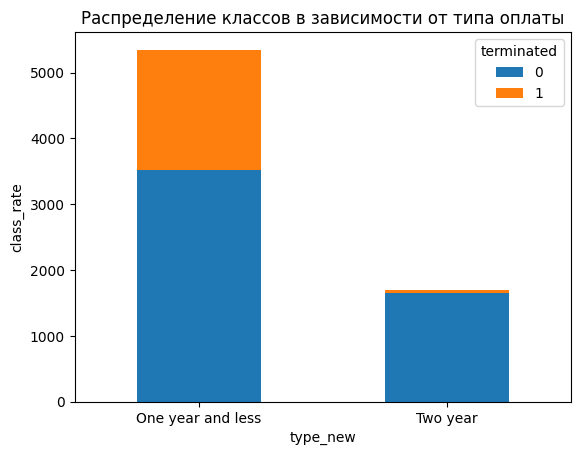

In [95]:
data['type_new'] = data['Type'].apply(lambda x: x if x == 'Two year' else 'One year and less')

(data
 .pivot_table(index='type_new', columns='terminated', aggfunc='size')
 .plot(kind='bar', stacked=True))

plt.xticks(rotation=0)
plt.title('Распределение классов в зависимости от типа оплаты')
plt.ylabel('class_rate')
plt.show()

Usually, those customers who choose this type of payment remain customers for a longer period of time and are less likely to terminate their contract with the telecom, as they make long-term plans for the use of these services. Customers who prefer to pay once a year or once a month are more likely to leave.

<a id='result'></a>
## Conclusions

Thus, this project proposed a machine learning based solution to solve the problem of customer churn for a telecom company.

The data were downloaded as separate tables contained in a PostgreSQL database, preprocessed and merged into a single dataframe. Also in the preprocessing stage, some new features were reviewed and synthesized considering their impact on the target variable. Since there was an imbalance of classes in the original data (1 to 4 in favor of the zero class), however, it was decided not to take special measures to deal with it, since it was planned to use cross-validation in further steps. The models were fed as input in a payplan format containing a preprocessing step (OHE coding for categorical features, scaling for numerical features).

During the search phase for a suitable model, 3 different classes of models were considered: *Random Forest*, *Gradient Boosting (catboost)* and a self-designed *neural network*. For each model, optimal hyperparameters were selected using *GridSearchCV*.

The best results were demonstrated by **model trained by catboost** (learning_rate=0.2,max_depth=4, n_estimators=19)  gradient-boosting algorithm using external coding of categorical features.

**ROC-AUC on traine:** 0.845786.\
**ROC-AUC on test:** 0.850155.

The obtained model is almost maximally capable of identifying customers who tend to abandon communication services in the future. Taking this feature into account will allow the customer to take measures to retain them in time. It will also be useful to take into account the importance of features that help the model to make a decision, i.e. to pay attention to what characterizes active customers (for example, the choice of payment format "once in 2 years").

It is certainly possible to improve the model. For example, we can try to change data preprocessing, create new attributes and further analyze the importance of existing ones. We can also further explore other machine learning models or try to go deeper into building a neural network by carefully thinking about its architecture.